In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
from pickle import load as Pload
from pickle import dump as Pdump
from ds_ame import Datas

In [10]:
# LOAD Datas()
file = open("../../data/ame/NN_linear_deg5.txt", "rb")
data_ame = Pload(file)
file.close()
print(np.shape(data_ame.Ms))

file = open("../../data/NN_linear_deg5.txt", "rb")
data = Pload(file)
file.close()
print(np.shape(data.M))


(22, 200, 5)
(22, 200, 3)


## Analysis

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ["o", ">", "s"]
#M_strategies = ["our_M", "qiskit_M"]
labels = ["AME", "our_M"]

## Final M value

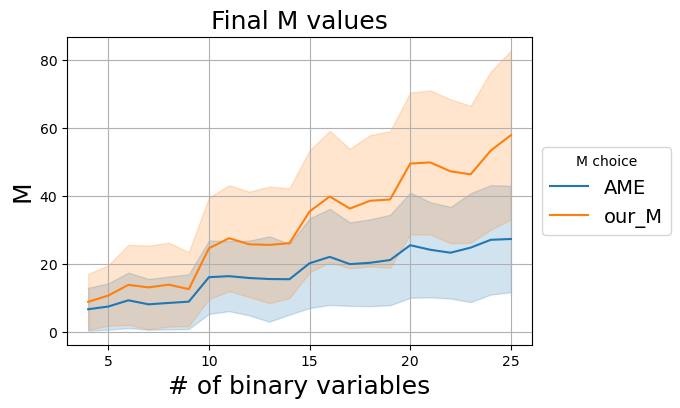

In [12]:
def statistics_M_ame(data):
    avg = np.mean(data.Ms.max(axis = 2), axis = 1)
    std = np.std(data.Ms.max(axis = 2), axis = 1)
    return avg, std

def statistics_M(data):
    avg = np.mean(data.M[...,0], axis = 1)
    std = np.std(data.M[...,0], axis = 1)
    return avg, std

avg_M_ame, std_M_ame = statistics_M_ame(data_ame)
avg_M, std_M = statistics_M(data)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Final M values', fontsize = 18)
ax1.set_xlabel('# of binary variables', fontsize = 18)
ax1.set_ylabel('M', fontsize = 18)
plt.plot(data_ame.bvars, avg_M_ame, color = colors[0], label = labels[0])
plt.fill_between(data_ame.bvars, avg_M_ame - std_M_ame, avg_M_ame + std_M_ame, color = colors[0], alpha=.2)
plt.plot(data.bvars, avg_M, color = colors[1], label = labels[1])
plt.fill_between(data.bvars, avg_M - std_M, avg_M + std_M, color = colors[1], alpha=.2)
""" for var_idx in range(len(data.bvars)):
    y = data.M[var_idx, :, i]
    x = data.bvars[var_idx] * np.ones((len(y)))
    plt.scatter(x, y, color = colors[i], alpha=.3) """
plt.grid()
#plt.ylim(0, 50)
#plt.xlim(5, 10)
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Fitting M

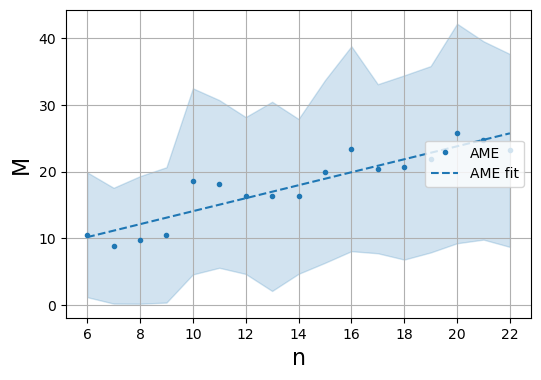

Ame fit:	0.97x+4.31
0.9737254901960212 \pm 0.11240443235643757
4.308137254909176 \pm 1.6672271819013995


In [7]:
f = lambda n, a, b: a*n + b
f2 = lambda n, a, b: a*n**2 + b*n
funct = f
n_parameters = 2
n_fit = 1

start_point = 0

coef = np.ndarray((n_parameters, n_fit))
coef_cov = np.ndarray((n_parameters, n_parameters, n_fit))
coef_err = np.ndarray((n_parameters, n_fit))
for i in range(n_fit):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data_ame.bvars[start_point:], avg_M_ame[start_point:])
    coef_err[:,i] = np.sqrt( np.diag(coef_cov[...,i]) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
#ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('M', fontsize = 16)
plt.plot(data_ame.bvars, avg_M_ame, ".", color = colors[i], label=labels[i])
plt.fill_between(data_ame.bvars, avg_M_ame - std_M_ame, avg_M_ame + std_M_ame, color = colors[i], alpha=.2)
plt.plot(data_ame.bvars, funct(data_ame.bvars, *coef[:,i]), "--", color = colors[i], label=labels[i]+" fit")
plt.grid()
#plt.ylim(0, 250)
#plt.yscale("log")
ax1.legend(fontsize = 10, loc='center right')
#ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

words = ["Ame", "Our_M", "Optimal"]
for i in range(n_fit):
    print(f"{words[i]} fit:\t{np.round(coef[0,i], 2)}x+{np.round(coef[1,i], 2)}")
    print(f"{coef[0,i]} \pm {coef_err[0,i]}")
    print(f"{coef[1,i]} \pm {coef_err[1,i]}")

### Distinguishing Final Ms greater or lower than Our M

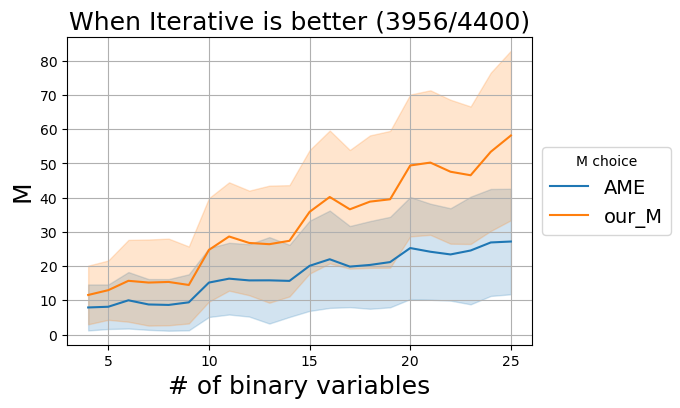

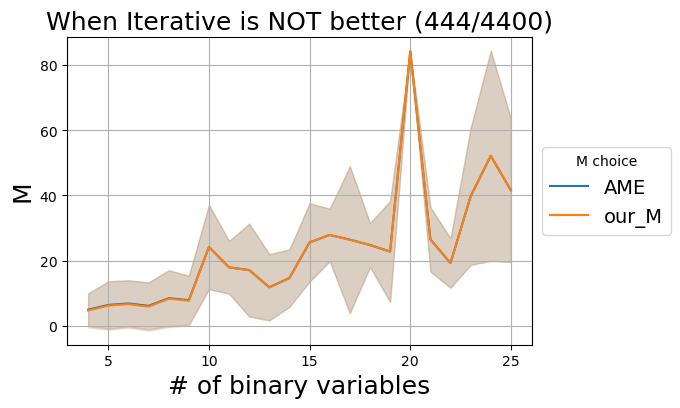

In [13]:
def statistics_M_distinguish(data, data_ame):
    final_M = data_ame.Ms.max(axis = 2)
    our_M = data.M[..., 0]
    is_better = final_M < our_M

    ib_num = np.sum(is_better)
    n_bvars, n_samples = np.shape(our_M)
    inb_num = n_bvars*n_samples - ib_num

    inb_ame_mean = np.mean(  np.ma.masked_array(final_M, mask = is_better) , axis = 1)
    inb_ame_std = np.std(  np.ma.masked_array(final_M, mask = is_better) , axis = 1) 
    inb_our_mean = np.mean(  np.ma.masked_array(our_M, mask = is_better) , axis = 1)
    inb_our_std = np.std(  np.ma.masked_array(our_M, mask = is_better) , axis = 1)   
    ib_ame_mean = np.mean(  np.ma.masked_array(final_M, mask = 1 - is_better) , axis = 1)
    ib_ame_std = np.std(  np.ma.masked_array(final_M, mask = 1 - is_better) , axis = 1) 
    ib_our_mean = np.mean(  np.ma.masked_array(our_M, mask = 1 - is_better) , axis = 1)
    ib_our_std = np.std(  np.ma.masked_array(our_M, mask = 1 - is_better) , axis = 1)    
    return (inb_ame_mean, inb_ame_std, inb_our_mean, inb_our_std, inb_num), (ib_ame_mean, ib_ame_std, ib_our_mean, ib_our_std, ib_num)

(inb_ame_mean, inb_ame_std, inb_our_mean, inb_our_std, inb_num), (ib_ame_mean, ib_ame_std, ib_our_mean, ib_our_std, ib_num) = statistics_M_distinguish(data, data_ame)

n_bvars, n_samples, _ = np.shape(data_ame.Ms)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title(f'When Iterative is better ({ib_num}/{n_bvars*n_samples})', fontsize = 18)
ax1.set_xlabel('# of binary variables', fontsize = 18)
ax1.set_ylabel('M', fontsize = 18)
plt.plot(data_ame.bvars, ib_ame_mean, color = colors[0], label = labels[0])
plt.fill_between(data_ame.bvars, ib_ame_mean - ib_ame_std, ib_ame_mean + ib_ame_std, color = colors[0], alpha=.2)
plt.plot(data.bvars, ib_our_mean, color = colors[1], label = labels[1])
plt.fill_between(data_ame.bvars, ib_our_mean - ib_our_std, ib_our_mean + ib_our_std, color = colors[1], alpha=.2)
plt.grid()
#plt.ylim(0, 50)
#plt.xlim(5, 10)
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title(f'When Iterative is NOT better ({inb_num}/{n_bvars*n_samples})', fontsize = 18)
ax1.set_xlabel('# of binary variables', fontsize = 18)
ax1.set_ylabel('M', fontsize = 18)
plt.plot(data_ame.bvars, inb_ame_mean, color = colors[0], label = labels[0])
plt.fill_between(data_ame.bvars, inb_ame_mean - inb_ame_std, inb_ame_mean + inb_ame_std, color = colors[0], alpha=.2)
plt.plot(data.bvars, inb_our_mean, color = colors[1], label = labels[1])
plt.fill_between(data_ame.bvars, inb_our_mean - inb_our_std, inb_our_mean + inb_our_std, color = colors[1], alpha=.2)
plt.grid()
#plt.ylim(0, 50)
#plt.xlim(5, 10)
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Number of steps

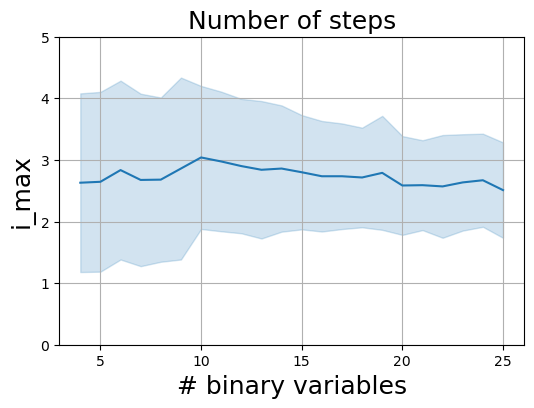

In [14]:
def statistics_steps(data):
    avg = np.mean(data.max_iter, axis = 1)
    std = np.std(data.max_iter, axis = 1)
    return avg, std

avg, std = statistics_steps(data_ame)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Number of steps', fontsize = 18)
ax1.set_xlabel('# binary variables', fontsize = 18)
ax1.set_ylabel('i_max', fontsize = 18)
plt.plot(data_ame.bvars, avg, color = colors[0], label = labels[0])
plt.fill_between(data_ame.bvars, avg - std, avg + std, color = colors[0], alpha=.2)
plt.ylim(0,5)
plt.grid()
plt.show()

## Gap study

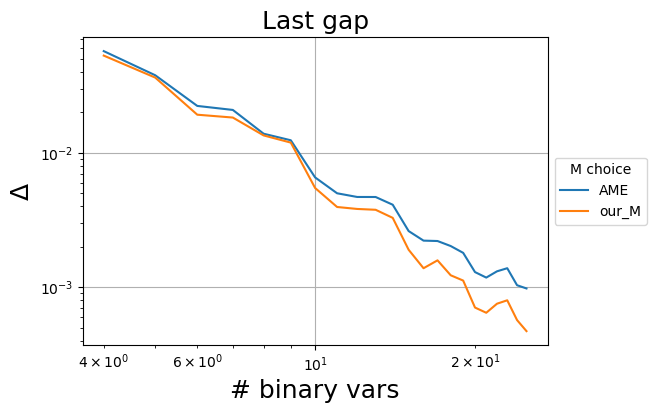

In [15]:
def statistics_last_gap(data):
    n_vars, n_samples, _ = np.shape(data.Ms)
    last_gap = np.ndarray((n_vars, n_samples))
    for i in range(n_vars):
        for j in range(n_samples):
            last_gap[i, j] = data.gaps[i, j, data.max_iter[i,j]-1]
    return np.mean(last_gap, axis = 1), np.std(last_gap, axis = 1)

def statistics_gaps(data):
    avg_k = np.mean(data.gap_norm[..., 0], axis = 1)
    std_k = np.std(data.gap_norm[..., 0], axis = 1)
    return avg_k, std_k


avg_d_ame, std_d_ame = statistics_last_gap(data_ame)
avg_d, std_d = statistics_gaps(data)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Last gap', fontsize = 18)
ax1.set_xlabel('# binary vars', fontsize = 18)
ax1.set_ylabel('$\Delta$', fontsize = 18)
plt.plot(data_ame.bvars, avg_d_ame, label = labels[0])
#plt.fill_between(data_ame.bvars, avg_d_ame - std_d_ame, avg_d_ame + std_d_ame, alpha = .2)
plt.plot(data.bvars, avg_d, label = labels[1])
#plt.fill_between(data.bvars[fromm:tto], avg_d - std_d, avg_d + std_d, alpha = .2)
plt.grid()
plt.yscale("log")
plt.xscale("log")
ax1.legend(title = 'M choice', fontsize = 10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [91]:
""" def statistics_gaps(data):
    avg_k = np.mean(data.gaps, axis = 1)
    std_k = np.std(data.gaps, axis = 1)
    return avg_k, std_k

avg_g, std_g = statistics_gaps(data_ame)
n_bvars, n_samples, n_iters = np.shape(data_ame.Ms)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Trend gap', fontsize = 18)
ax1.set_xlabel('iteration step (i)', fontsize = 18)
ax1.set_ylabel('$\Delta_i$', fontsize = 18)
for i in range(n_bvars):
    plt.plot(np.arange(1, n_iters + 1), avg_g[i], label = data_ame.bvars[i])
    plt.fill_between(np.arange(1, n_iters + 1), avg_g[i] - std_g[i], avg_g[i] + std_g[i], alpha = .2)
plt.grid()
ax1.legend(title = 'M choice', fontsize = 10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() """

## This plot makes no sense like this, since it involves also zeros put by tdefault for some samples where the algorithms is actually terminated

" def statistics_gaps(data):\n    avg_k = np.mean(data.gaps, axis = 1)\n    std_k = np.std(data.gaps, axis = 1)\n    return avg_k, std_k\n\navg_g, std_g = statistics_gaps(data_ame)\nn_bvars, n_samples, n_iters = np.shape(data_ame.Ms)\n\nfig = plt.figure(figsize=(6,4))\nax1 = fig.add_subplot(1,1,1)\nax1.set_title('Trend gap', fontsize = 18)\nax1.set_xlabel('iteration step (i)', fontsize = 18)\nax1.set_ylabel('$\\Delta_i$', fontsize = 18)\nfor i in range(n_bvars):\n    plt.plot(np.arange(1, n_iters + 1), avg_g[i], label = data_ame.bvars[i])\n    plt.fill_between(np.arange(1, n_iters + 1), avg_g[i] - std_g[i], avg_g[i] + std_g[i], alpha = .2)\nplt.grid()\nax1.legend(title = 'M choice', fontsize = 10, loc='center left', bbox_to_anchor=(1, 0.5))\nplt.show() "

In [16]:
def compute_gap_cost(data):
    n_vars, n_samples, _ = np.shape(data.Ms)
    cost = np.ndarray((n_vars, n_samples))
    for i in range(n_vars):
        for j in range(n_samples):
            cost[i, j] = np.sum( 1/data.gaps[i, j, :data.max_iter[i,j]] )
    return cost

cost_ame = compute_gap_cost(data_ame)
cost_our = 1/data.gap_norm[..., 0]
diff_cost = cost_our - cost_ame
ratio_cost = cost_our / cost_ame

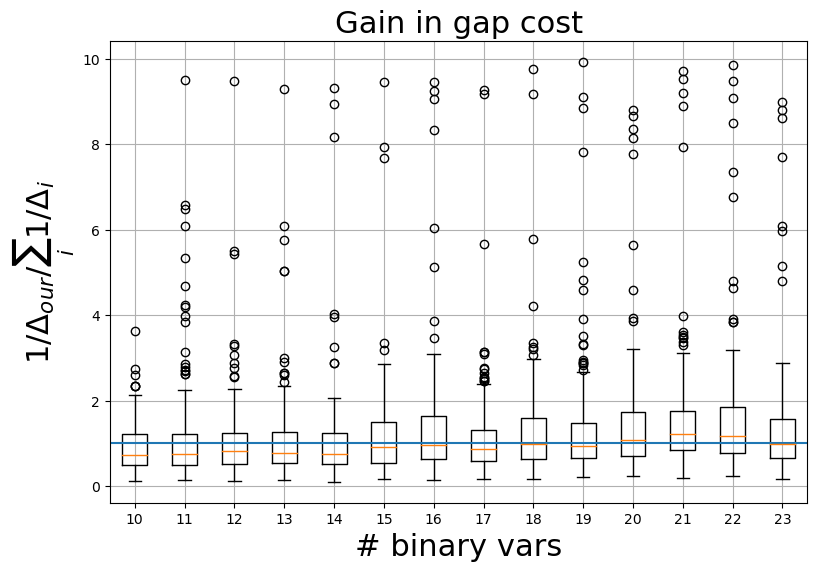

In [17]:
vars_to_plot = list(np.arange(6,20))

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Gain in gap cost', fontsize = 22)
ax1.set_xlabel('# binary vars', fontsize = 22)
ax1.set_ylabel('$1/\Delta_{our} / \sum_i 1/\Delta_i$', fontsize = 22)
ax1.boxplot(np.swapaxes(ratio_cost[vars_to_plot], axis1=0, axis2=1), labels = data_ame.bvars[vars_to_plot])
#plt.ylim(0,10)
plt.axhline(1)
plt.grid()
plt.show()

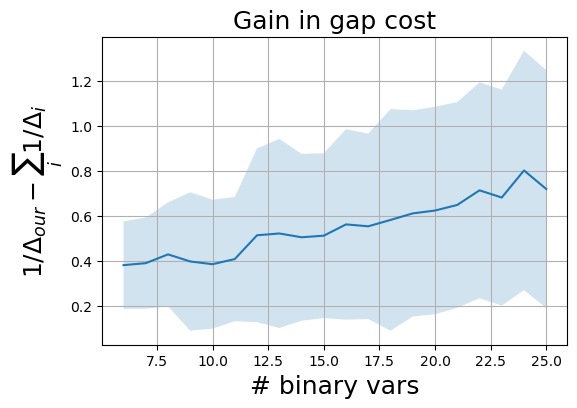

In [12]:
avg, std = np.mean(ratio_cost, axis = 1), np.std(ratio_cost, axis = 1)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Gain in gap cost', fontsize = 18)
ax1.set_xlabel('# binary vars', fontsize = 18)
ax1.set_ylabel('$1/\Delta_{our} - \sum_i 1/\Delta_i$', fontsize = 18)
plt.plot(data_ame.bvars, avg)
plt.fill_between(data_ame.bvars, avg - std, avg + std, alpha = .2)
plt.grid()
#ax1.legend(title = 'M choice', fontsize = 10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Fit of gaps

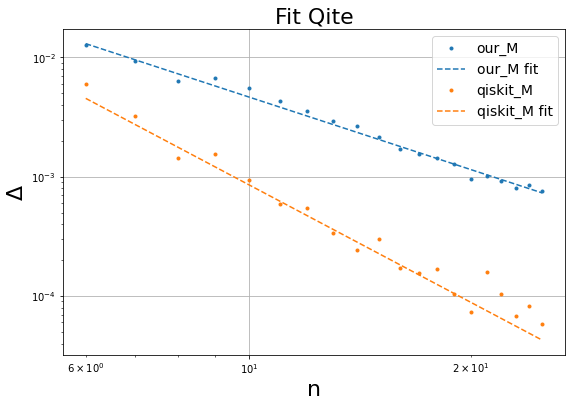

Our fit: 0.48 x^-2.02
a:	0.483 \pm 0.564
b:	-2.018 \pm 0.446

Qiskit fit: 1.58 x^-3.27
a:	1.581 \pm 2.793
b:	-3.268 \pm 0.68



In [43]:
f_pl = lambda x, a, b : a*x**b
f_exp = lambda x, a, b : a*b**x
funct = f_pl

n_parameters = 2
endpoint = 22
startpoint = 0
n_M = 2

coef = np.ndarray((n_parameters, n_M))
coef_cov = np.ndarray((n_parameters, n_parameters, n_M))
coef_err = np.ndarray((n_parameters, n_M))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[startpoint:endpoint], avg_gap_qite[startpoint:endpoint,i],
                                sigma = std_gap_qite[startpoint:endpoint,i],
                                absolute_sigma = True)
    coef_err[:,i] = np.sqrt(np.diag(coef_cov[...,i]))
# sigma in curve_fit gives the uncertainty in ydata

def RSS(x, y, f):
    return np.sum( np.square(y - f(x)) )

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Fit Qite', fontsize = 22)
ax1.set_xlabel('n', fontsize = 22)
ax1.set_ylabel('$\Delta$', fontsize = 22)
for i in range(n_M):
    if plot_M[i]:
        #plt.plot(data.bvars[:10], avg_gap_adiabatic[:10,i], label=M_strategies[i]+" Adiab",  color = colors[i])
        plt.plot(data.bvars[:endpoint], avg_gap_qite[:endpoint,i], ".", label=M_strategies[i],  color = colors[i])
        """ plt.fill_between(data.bvars[:endpt_qite], avg_gap_qite[:endpt_qite,i] - std_gap_qite[:endpt_qite,i],
                         avg_gap_qite[:endpt_qite,i] + std_gap_qite[:endpt_qite,i], alpha=.2,  color = colors[i]) """
        plt.plot(data.bvars[:endpoint], funct(data.bvars[:endpoint], *coef[:,i]), "--", color = colors[i], label=M_strategies[i]+" fit")
plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.ylim(0, .05)
#plt.xlim(9, 26)
ax1.legend(fontsize = 14, loc='upper right')
plt.show() 


word = ["Our", "Qiskit", "Optimal"]
for i in range(n_M):
    print(f"{word[i]} fit: {np.round(coef[0,i], 2)} x^{np.round(coef[1,i], 2)}")
    print(f"a:\t{np.round(coef[0,i], 3)} \pm {np.round(coef_err[0,i], 3) }")
    print(f"b:\t{np.round(coef[1,i], 3)} \pm {np.round(coef_err[1,i], 3) }\n")
    #r = RSS( data.bvars[startpoint:endpoint], avg_gap_qite[startpoint:endpoint,i], lambda x : funct(x, *coef[:,i]))
    #print(f"RSS (wrt mean) value {np.round(r, 7)}")

In [2]:
""" file = open("../../data/ame/SPP_p15.txt", "rb")
data_base = Pload(file)
file.close()

file = open("../../data/ame/SPP_p15_extension.txt", "rb")
data_extend = Pload(file)
file.close()

bvars_extend = np.arange(23, 26)

def glue_datas_bybvars(data_base, data_extend, bvars_extend):
    break_idx = len(bvars_extend)
    _, n_samples = np.shape(data_extend.is_optimum)
    bvars = np.append(data_base.bvars, bvars_extend)
    data = Datas(bvars, n_samples)
    data.is_optimum[:- break_idx ] = data_base.is_optimum
    data.is_optimum[- break_idx :] = data_extend.is_optimum
    data.fval_classic[:- break_idx ] = data_base.fval_classic
    data.fval_classic[- break_idx :] = data_extend.fval_classic
    data.max_iter[:- break_idx ] = data_base.max_iter
    data.max_iter[- break_idx :] = data_extend.max_iter

    # strucs depending on max_iter
    _, _, max_base = np.shape(data_base.gaps)
    _, _, max_extend = np.shape(data_extend.gaps)
    max_iter_tot = max(max_base, max_extend)
    data.Ms, data.fvals = np.zeros((len(bvars), n_samples, max_iter_tot)), np.zeros((len(bvars), n_samples, max_iter_tot))
    data.gaps, data.violation_nums = np.zeros((len(bvars), n_samples, max_iter_tot)), np.zeros((len(bvars), n_samples, max_iter_tot))
 
    data.gaps[:- break_idx , :, :max_base] = data_base.gaps
    data.gaps[- break_idx :, :, :max_extend] = data_extend.gaps
    data.fvals[:- break_idx , :, :max_base] = data_base.fvals
    data.fvals[- break_idx :, :, :max_extend] = data_extend.fvals
    data.Ms[:- break_idx , :, :max_base] = data_base.Ms
    data.Ms[- break_idx :, :, :max_extend] = data_extend.Ms
    data.violation_nums[:- break_idx , :, :max_base] = data_base.violation_nums
    data.violation_nums[- break_idx :, :, :max_extend] = data_extend.violation_nums
    return data


data = glue_datas_bybvars(data_base, data_extend, bvars_extend)

file = open("../../data/ame/SPP_p15_all.txt", "wb")
Pdump(data, file)
file.close() """